In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from scipy.stats import f, ttest_ind, chi2_contingency

# 1. Datasets

In [2]:
group_data = pd.read_csv('/Users/wuchenhong/Documents/BIA_courses/BIA686/BIA_686_Team1-master/output/result.csv')

In [3]:
specific_data = pd.read_csv('/Users/wuchenhong/Documents/BIA_courses/BIA686/BIA_686_Team1-master/output/final_data.csv')

In [4]:
print(group_data.shape)
group_data.isnull().sum()

(225, 21)


Topic_Year               0
Citation_feature         0
Topic_num                0
Five_Year_Percent        0
Three_Year_Percent       0
Sum_SJR                  0
Avg_SJR                  0
Year                     0
Topic                    0
Growth_Rate              0
Citation_Growth_Rate     0
Year_Growth_Rate         0
Target                   0
Avg_SJR_1                0
Avg_SJR_2                0
Avg_SJR_3               15
Sum_SJR_1                0
Sum_SJR_2                0
Sum_SJR_3               15
Google Trend             0
Review_AMT               0
dtype: int64

In [5]:
print(specific_data.shape)
specific_data.isnull().sum()

(46169, 13)


Cluster_Topic                       0
PY                                  0
Topic_Year                          0
PT                                  0
PG                                  0
Have_Funding_Agency                 0
Author_count                        0
Funding_agency_count                0
Squeezed_Publisher                  0
Contain_Top_All_authors             0
Contain_Top_All_funding_agencies    0
Count_of_top_funding_agency         0
Contain_Top_PU                      0
dtype: int64

In [6]:
# Merge two datasets into one by key 'Topic_Year'
final_data = group_data.merge(specific_data, how='right', on='Topic_Year')

In [7]:
del group_data
del specific_data

In [8]:
# Filter data after year 2000
final_data = final_data[(final_data.PY >= 2000) & (final_data.PY < 2019)]

In [9]:
# Remove overlapped features
final_data.drop(columns=['PY','Cluster_Topic'], inplace=True)
final_data.isnull().sum()

Topic_Year                             0
Citation_feature                    2669
Topic_num                           2669
Five_Year_Percent                   2669
Three_Year_Percent                  2669
Sum_SJR                             2669
Avg_SJR                             2669
Year                                2669
Topic                               2669
Growth_Rate                         2669
Citation_Growth_Rate                2669
Year_Growth_Rate                    2669
Target                              2669
Avg_SJR_1                           2669
Avg_SJR_2                           2669
Avg_SJR_3                           3643
Sum_SJR_1                           2669
Sum_SJR_2                           2669
Sum_SJR_3                           3643
Google Trend                        2669
Review_AMT                          2669
PT                                     0
PG                                     0
Have_Funding_Agency                    0
Author_count    

In [10]:
# Drop off missing records from Growth_Rate (target variable)
final_data = final_data[~final_data.Growth_Rate.isnull()]

In [11]:
# Missing data imputation by replacing median values
missing_cols = []
for col in final_data.columns:
    if final_data[col].isnull().sum() != 0:
        missing_cols.append(col)

In [12]:
missing_cols

['Avg_SJR_3', 'Sum_SJR_3']

In [13]:
for missing_col in missing_cols:
    final_data[missing_col].fillna(np.nanmedian(final_data[missing_col]), inplace=True)

In [14]:
final_data.isnull().sum()

Topic_Year                          0
Citation_feature                    0
Topic_num                           0
Five_Year_Percent                   0
Three_Year_Percent                  0
Sum_SJR                             0
Avg_SJR                             0
Year                                0
Topic                               0
Growth_Rate                         0
Citation_Growth_Rate                0
Year_Growth_Rate                    0
Target                              0
Avg_SJR_1                           0
Avg_SJR_2                           0
Avg_SJR_3                           0
Sum_SJR_1                           0
Sum_SJR_2                           0
Sum_SJR_3                           0
Google Trend                        0
Review_AMT                          0
PT                                  0
PG                                  0
Have_Funding_Agency                 0
Author_count                        0
Funding_agency_count                0
Squeezed_Pub

In [16]:
# Create another target variable based on Growth_Rate for following hypothesis testing.
final_data['target'] = final_data.Growth_Rate.apply(lambda x : 0 if x <= 0 else 1) 

In [17]:
final_data.drop(['Target','Growth_Rate'], axis=1, inplace=True)

# 2. Feature Selection - Visualization & Hypothesis testing
- **2.1 Distribution plots - numerical features VS response**
- **2.2 Relationship between numerical predictors: Correlation Plot**
- **2.3 Distribution plots - categorical features**
- **2.4 Hypothesis testing - two sample t-test for numerical features**
- **2.5 Hypothesis testing - chi-square test for categorical features**
- **2.6 Overall feature selection summary**

## 2.1 Distribution plots - numerical features VS response

In [18]:
# Helper function for inspecting the relationship between numerical features 
# and the response variable.
def num_feature_distribution_plot(col_name, response_name, data):
    plt.figure(figsize = (10, 8))

    # KDE plot of y = 0 
    sb.kdeplot(data.loc[data[response_name] == 0, col_name], label = '0')
    
    # KDE plot of y = 1 
    sb.kdeplot(data.loc[data[response_name] == 1, col_name], label = '1')

    # Labeling
    plt.xlabel(col_name)
    plt.title('Distribution of '+ col_name, fontsize=20)

/Users/wuchenhong/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


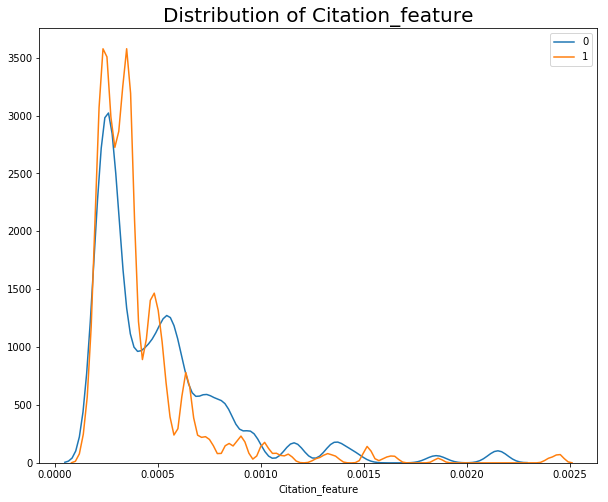

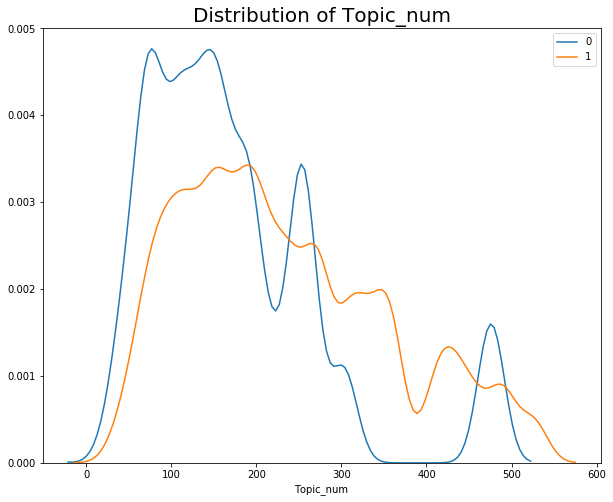

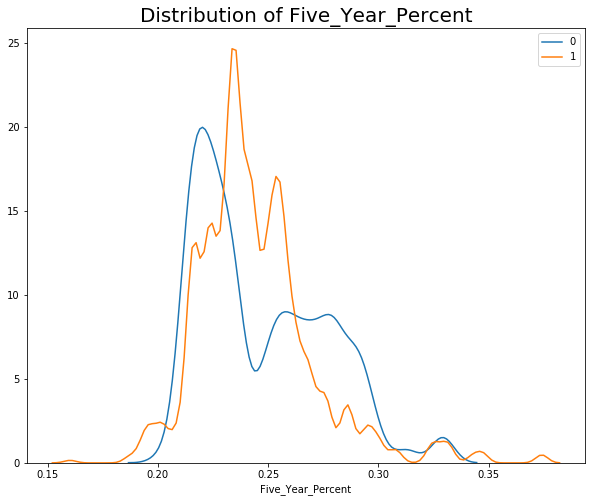

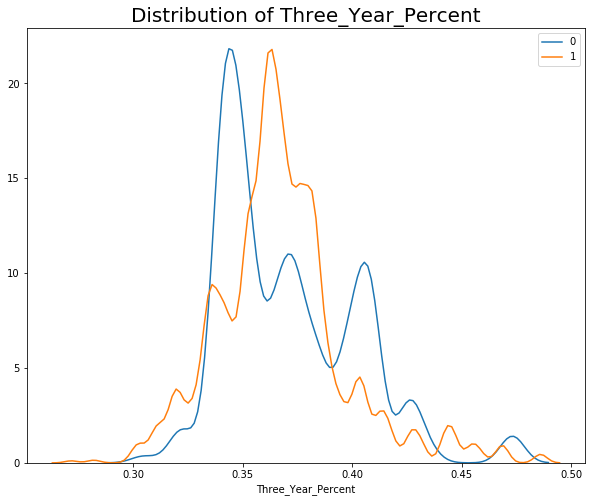

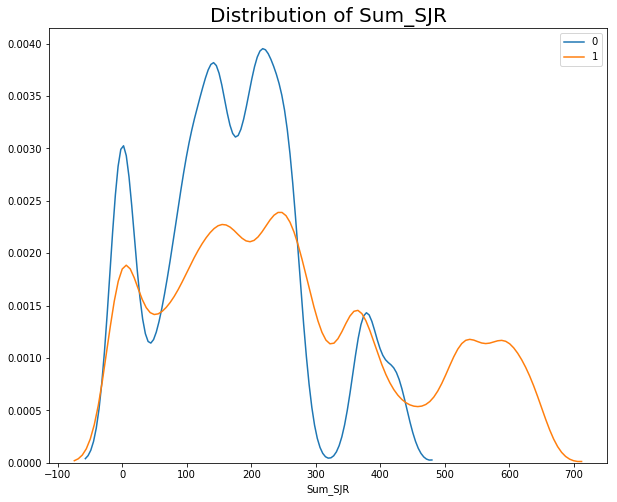

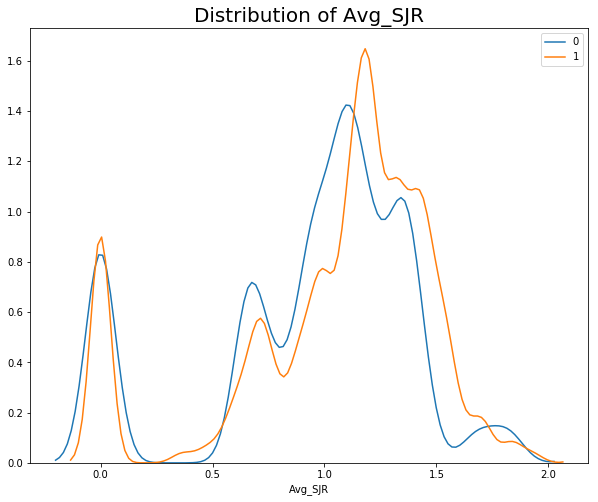

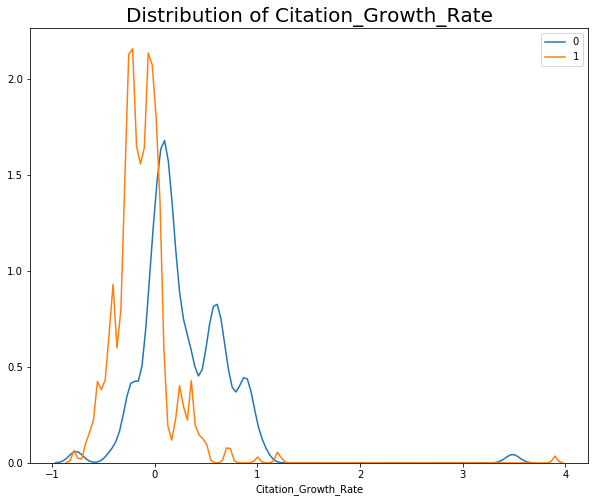

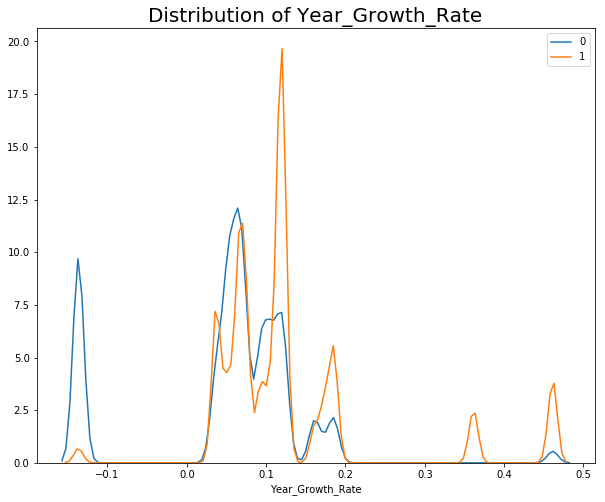

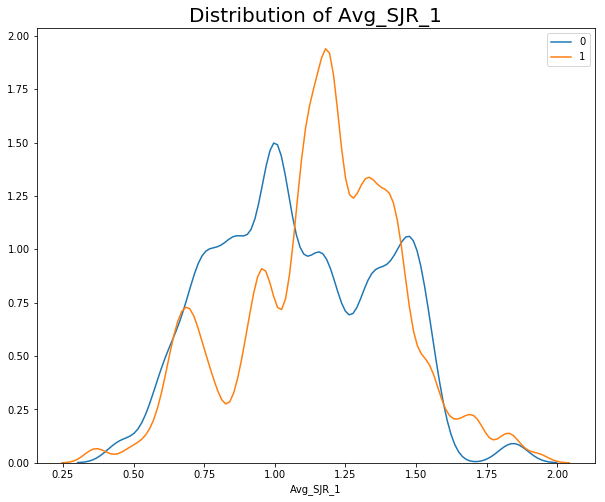

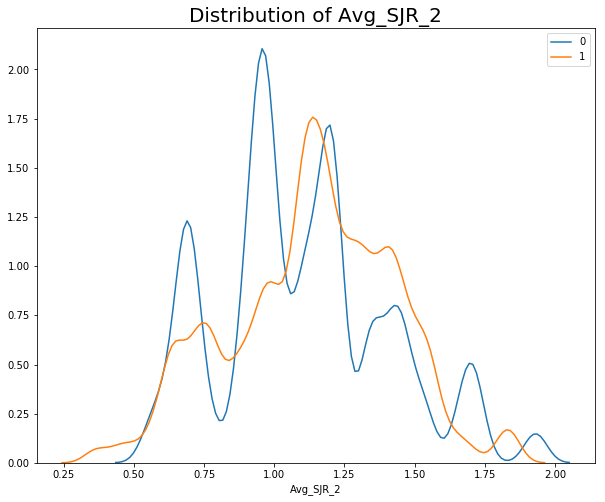

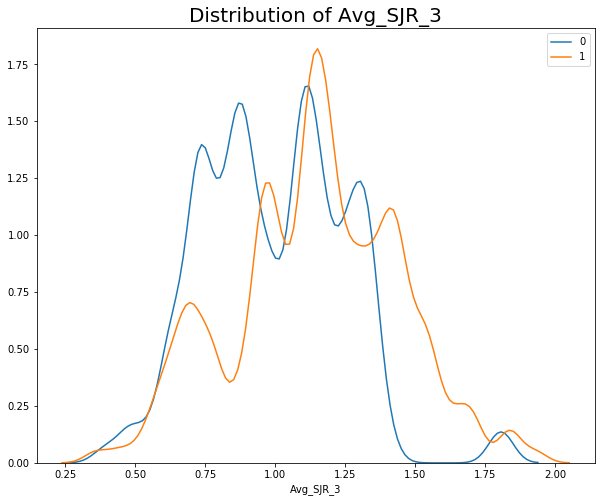

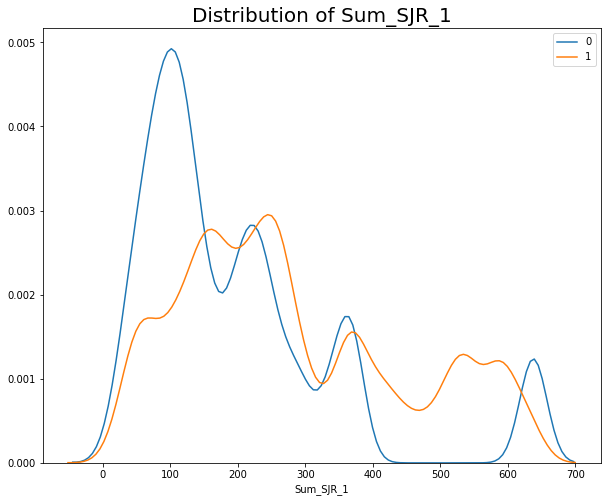

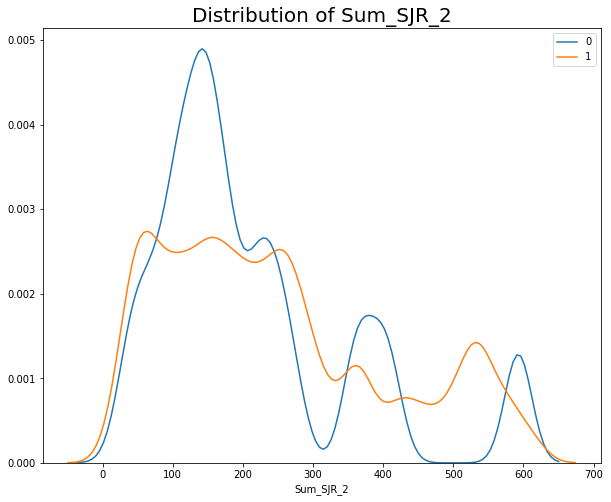

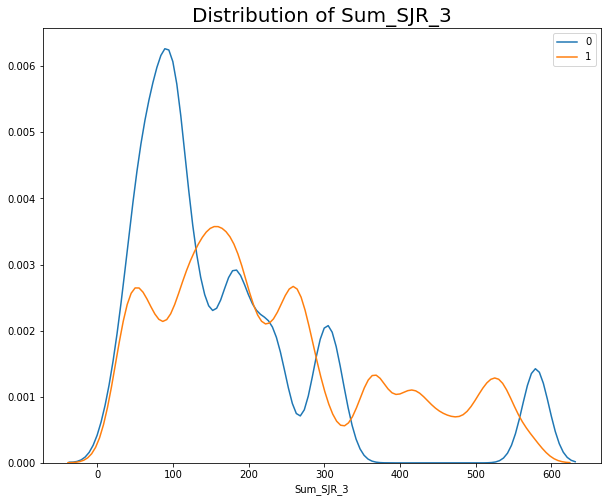

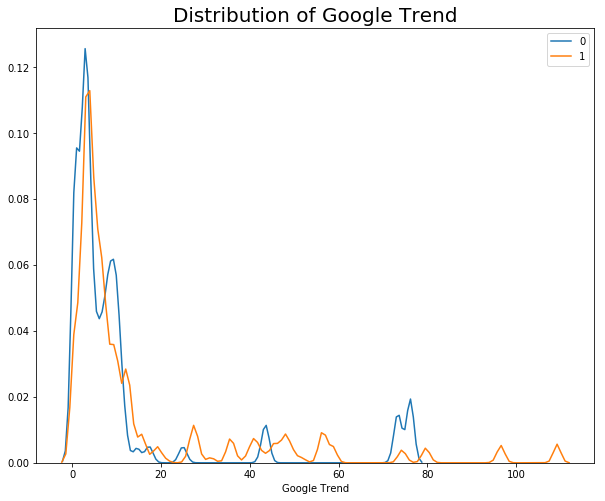

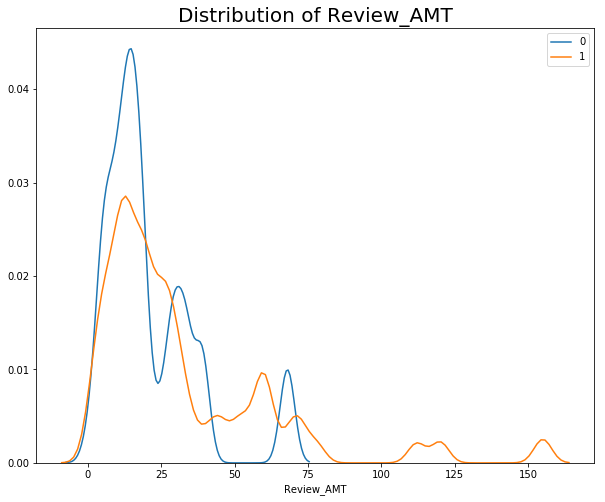

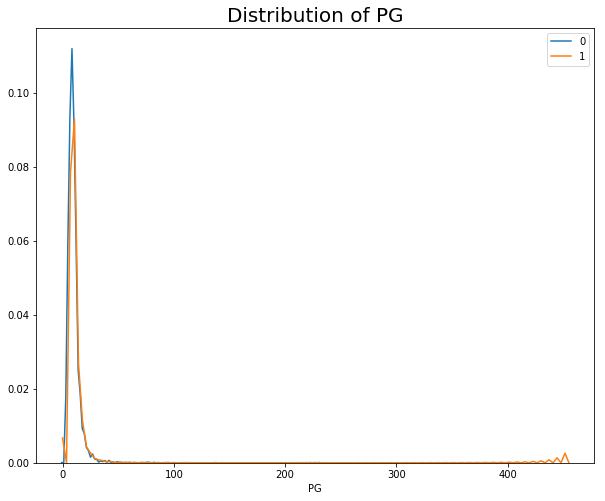

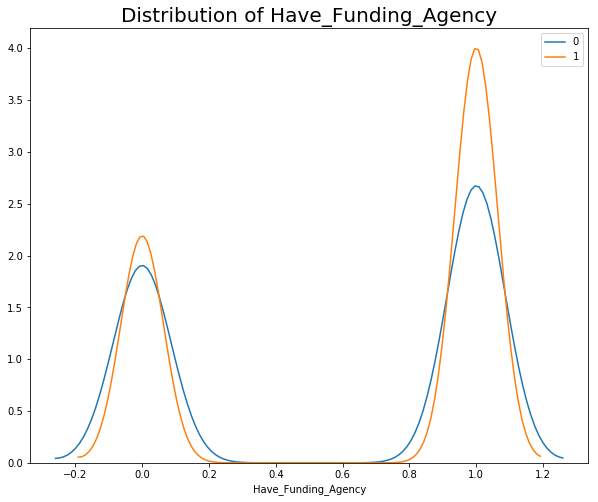

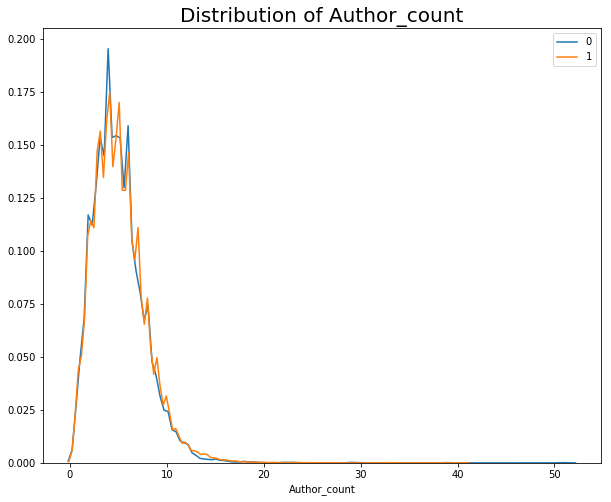

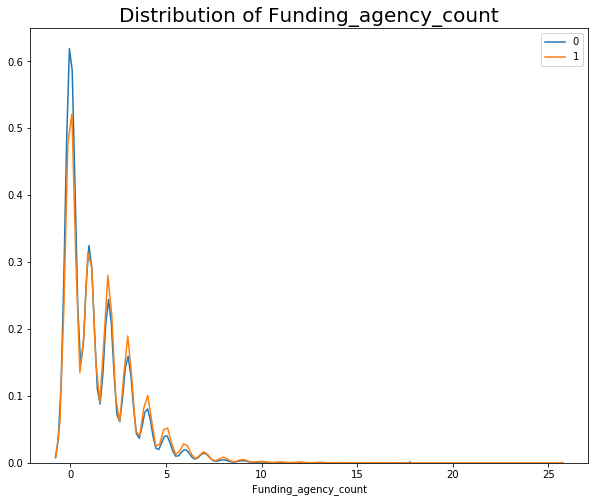

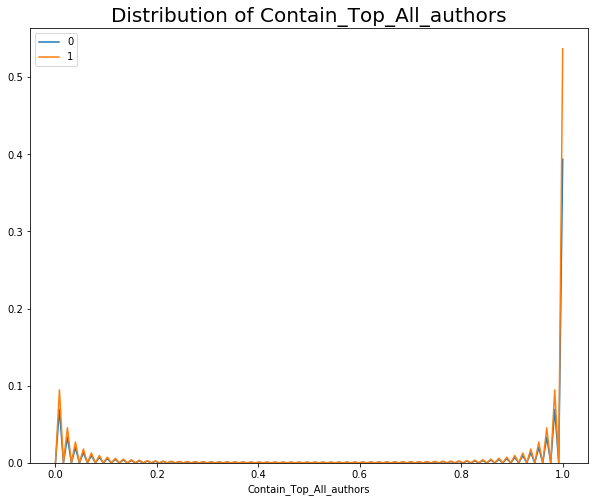

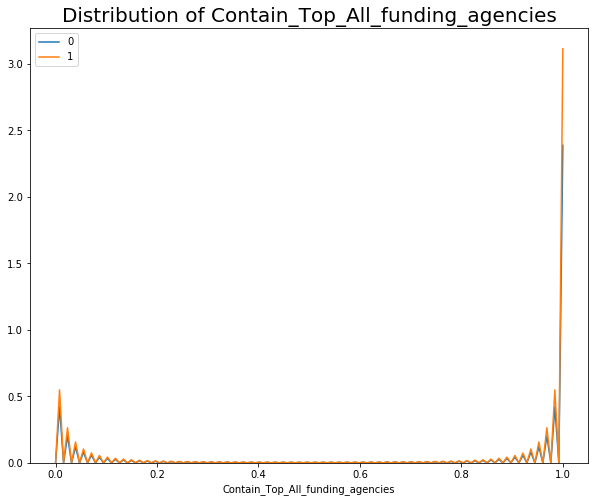

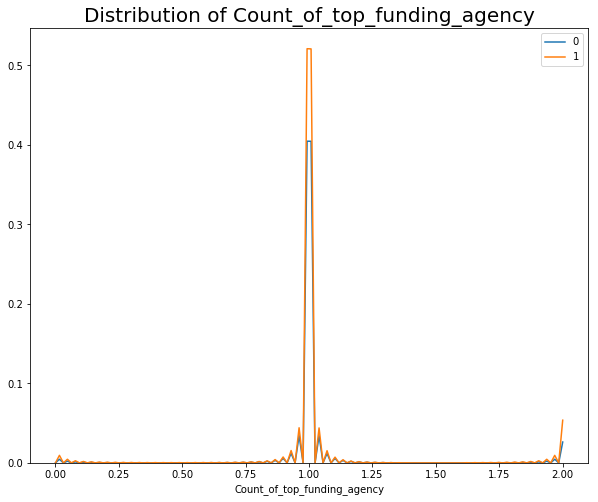

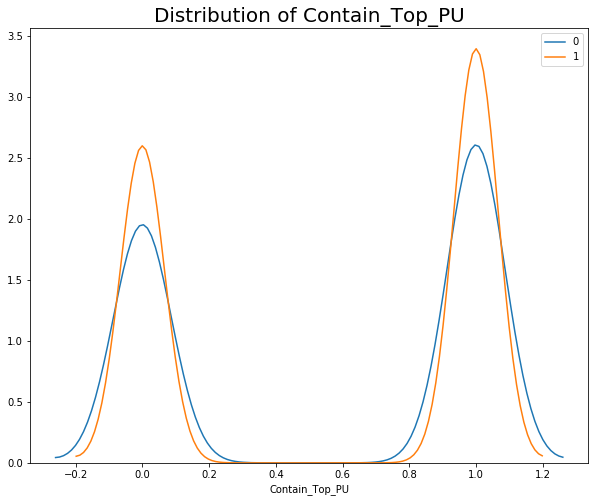

In [19]:
for col in final_data.columns:
    if (final_data[col].dtype != 'object') & (col not in ['target','Year','Topic']):
        num_feature_distribution_plot(col_name=col, response_name='target', data=final_data)

## 2.2 Relationship between numerical predictors: Correlation Plot

In [20]:
num_col_names = []
for col in final_data.columns:
    if (final_data[col].dtype != 'object'):
        num_col_names.append(col)
        
num_col_names.remove('Year')
num_col_names.remove('Topic')

correlation_matrix = final_data[num_col_names].corr()
mask = np.zeros_like(correlation_matrix)
mask[np.triu_indices_from(mask)] = True

In [21]:
# The correlation matrix shape is 26x26
correlation_matrix

,Citation_feature,Topic_num,Five_Year_Percent,Three_Year_Percent,Sum_SJR,Avg_SJR,Citation_Growth_Rate,Year_Growth_Rate,Avg_SJR_1,Avg_SJR_2,...,Review_AMT,PG,Have_Funding_Agency,Author_count,Funding_agency_count,Contain_Top_All_authors,Contain_Top_All_funding_agencies,Count_of_top_funding_agency,Contain_Top_PU,target
Citation_feature,1.000000,-0.414045,0.651289,0.549970,-0.166146,0.093543,0.366964,0.160600,-0.286069,-0.227296,...,-0.209389,-0.065649,-0.339123,-0.105334,-0.257961,0.015726,-0.028210,-0.028940,-0.017078,-0.118784
Topic_num,-0.414045,1.000000,-0.351236,-0.297327,0.550920,-0.143060,-0.124218,-0.220837,0.269777,0.293011,...,0.819527,0.138863,0.326012,0.150024,0.272462,-0.021298,0.024973,0.025793,0.043875,0.204441
Five_Year_Percent,0.651289,-0.351236,1.000000,0.928258,-0.024157,0.165360,0.160946,0.098382,-0.286749,-0.215878,...,-0.175230,-0.072995,-0.252151,-0.088818,-0.200943,0.011498,-0.019434,-0.020459,0.003966,-0.043835
Three_Year_Percent,0.549970,-0.297327,0.928258,1.000000,-0.022097,0.118474,0.196036,0.073853,-0.245378,-0.160243,...,-0.124147,-0.055699,-0.198920,-0.064863,-0.155945,0.011674,-0.018387,-0.018666,0.008416,-0.045364
Sum_SJR,-0.166146,0.550920,-0.024157,-0.022097,1.000000,0.658200,-0.047832,-0.136020,0.356934,0.405916,...,0.395486,0.051296,0.233238,0.070471,0.190108,-0.006712,0.028320,0.025994,0.041867,0.208501
Avg_SJR,0.093543,-0.143060,0.165360,0.118474,0.658200,1.000000,0.029832,0.010989,0.327640,0.314879,...,-0.155472,-0.043993,0.049404,-0.040873,0.030264,0.006421,0.017547,0.013574,0.013819,0.096729
Citation_Growth_Rate,0.366964,-0.124218,0.160946,0.196036,-0.047832,0.029832,1.000000,-0.227411,-0.201396,-0.011755,...,-0.025112,-0.008953,-0.040606,-0.009825,-0.029902,-0.001857,-0.010325,-0.010211,0.003747,-0.434204
Year_Growth_Rate,0.160600,-0.220837,0.098382,0.073853,-0.136020,0.010989,-0.227411,1.000000,-0.044865,-0.287877,...,-0.212081,-0.058293,-0.157266,-0.059100,-0.126586,0.007748,-0.016384,-0.017429,-0.026125,0.278071
Avg_SJR_1,-0.286069,0.269777,-0.286749,-0.245378,0.356934,0.327640,-0.201396,-0.044865,1.000000,0.739081,...,0.264450,0.084337,0.268650,0.071491,0.219053,-0.006253,0.040445,0.039450,0.037674,0.112007
Avg_SJR_2,-0.227296,0.293011,-0.215878,-0.160243,0.405916,0.314879,-0.011755,-0.287877,0.739081,1.000000,...,0.303626,0.085488,0.266959,0.072327,0.224897,0.001799,0.036505,0.035345,0.050413,0.042153


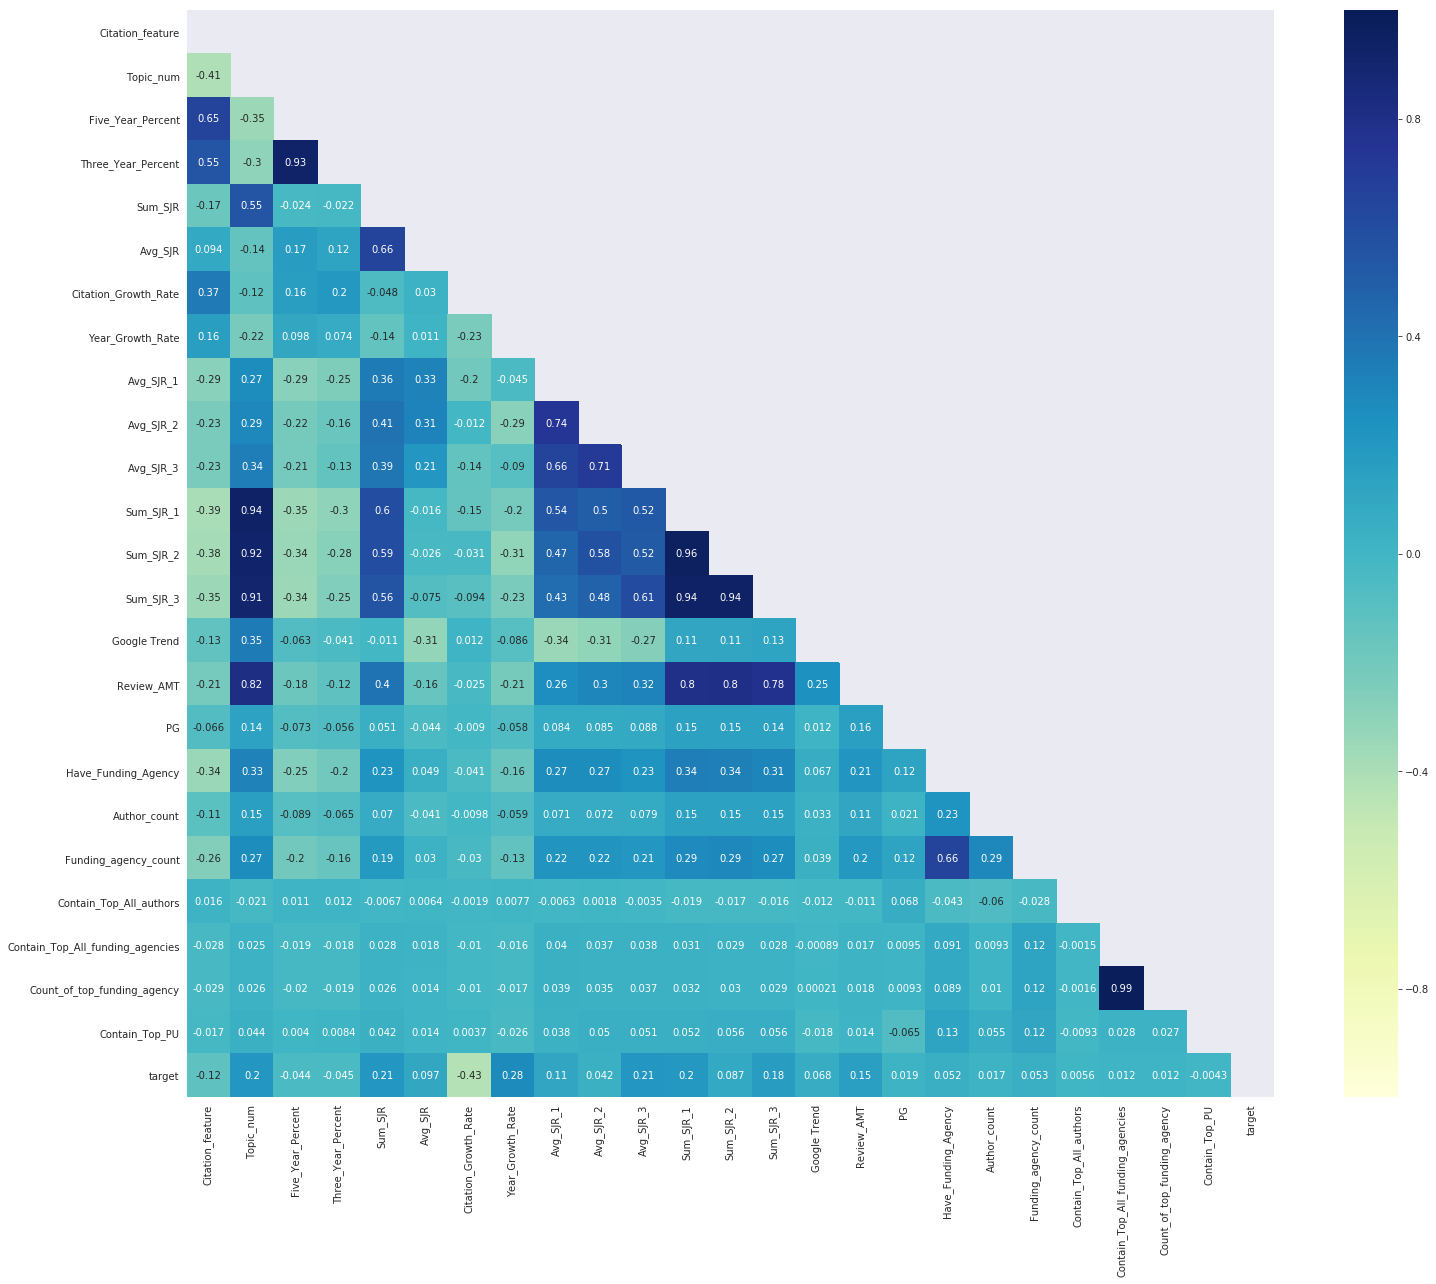

In [22]:
# Correlation plot helps me to inspect the relationship among numerical features.
# There might be a multicollinearity issue existed!
with sb.axes_style("darkgrid"):
    fig = plt.figure(figsize=(25,20))
    ax = sb.heatmap(correlation_matrix, mask = mask, 
                    vmin = -1, vmax = 1, square = True,
                    annot = True, cmap = "YlGnBu")
    plt.savefig('result.png', bbox_inches='tight', pad_inches=0.0)

## 2.3 Distribution plots - categorical features

In [23]:
# Helper function for inspecting the relationship between categorical features 
# and the response variable.
def cate_feature_distribution_plot(col_name, response_name, data):
    pd.crosstab(data[col_name], data[response_name]).plot(kind='bar')
    plt.title('Distribution of '+ col_name, fontsize=20)
    plt.xlabel('')
    plt.show()

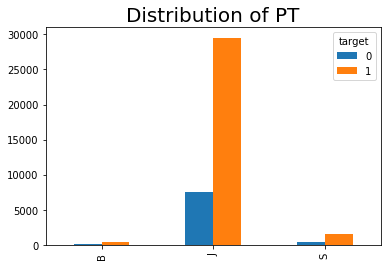

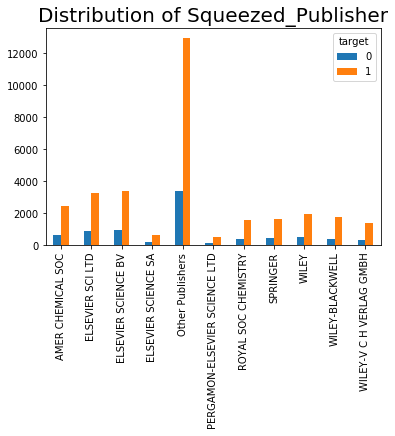

In [24]:
for col in final_data.columns:
    if (final_data[col].dtype == 'object') & (col != 'Topic_Year'):
        cate_feature_distribution_plot(col_name=col, response_name='target', data=final_data)

## 2.4 Hypothesis testing - two sample t-test for numerical features

In [25]:
# Helper function for performing an f-test to compare two sample variances.
def f_test_two_p_variance(var1, var2, n1, n2, alpha_level):
    '''
    Perform the F-test for comparing variances between two samples.
    Outputs: F ratio, p-value, and the confidence interval given an alpha level.
    
    var1: the variance of the population 1
    var2: the variance of the population 2
    n1: sample size of the population 1
    n2: sample size of the population 2
    alpha_level: can be either 0.1, 0.05, or 0.1
    '''
    # F test statistic
    F_ratio = var1 / var2
    
    # p-value (two-sided test: the interest is to compare whether two variances are equal)
    p_value = min(f.cdf(F_ratio, n1-1, n2-1), 1 - f.cdf(F_ratio, n1-1, n2-1))
    p_value = p_value*2

    # 95% C.I.
    upper = 1 / (f.ppf(alpha_level/2, n1-1, n2-1)) * F_ratio
    lower = 1 / (f.ppf(1 - (alpha_level/2), n1-1, n2-1)) * F_ratio
    
    return F_ratio, p_value, (lower, upper)

In [26]:
# Loop into numerical columns.
unequal_var = []
equal_var = []
for num_col in num_col_names:
    if num_col != 'target':
        f_results = f_test_two_p_variance(var1=final_data[final_data.target == 0][num_col].var(), 
                                          var2=final_data[final_data.target == 1][num_col].var(), 
                                          n1=final_data[final_data.target == 0][num_col].count(), 
                                          n2=final_data[final_data.target == 1][num_col].count(), 
                                          alpha_level=0.05)
        print('Column name: {}.'.format(num_col))
        print('F ratio: {}.'.format(f_results[0]))
        print('p-value: {}.'.format(f_results[1]))
        print('95 C.I. {}.'.format(f_results[2]))
        if f_results[1] <= 0.05:
            print('Decision: reject H0, two variances are unequal.')
            unequal_var.append(num_col)
        else: 
            print('Decision: do not reject H0, two variances are equal.')
            equal_var.append(num_col)
        print('----------------------------------------------------')

Column name: Citation_feature.
F ratio: 1.501724229766553.
p-value: 2.220446049250313e-16.
95 C.I. (1.4509181781200724, 1.5548683440517912).
Decision: reject H0, two variances are unequal.
----------------------------------------------------
Column name: Topic_num.
F ratio: 0.7377467955782341.
p-value: 1.1820708687802494e-62.
95 C.I. (0.71278748477055, 0.7638547182185133).
Decision: reject H0, two variances are unequal.
----------------------------------------------------
Column name: Five_Year_Percent.
F ratio: 1.2133734398118798.
p-value: 2.220446049250313e-16.
95 C.I. (1.1723228178483964, 1.2563131856572667).
Decision: reject H0, two variances are unequal.
----------------------------------------------------
Column name: Three_Year_Percent.
F ratio: 1.1124272686230563.
p-value: 1.042158803699067e-09.
95 C.I. (1.07479183853387, 1.1517946576055922).
Decision: reject H0, two variances are unequal.
----------------------------------------------------
Column name: Sum_SJR.
F ratio: 0.363

In [28]:
# Perform two sample t-test to see whether they have 'different' means.
# If they are different to each other in the aspect of mean given a predictor, 
# then it might indicate this predictor has some prediction power 
# on the response variable

# Collecting results.
t_test_results = np.array([])
t_test_p_values = np.array([])
num_col_names = np.array([])

# Loop into numerical columns - unequal variance case.
for num_col in unequal_var:
    t_test_results = np.append(t_test_results,
                               (ttest_ind(a=final_data[final_data.target == 0][num_col], 
                                          b=final_data[final_data.target == 1][num_col], 
                                          equal_var=False))[0])
    t_test_p_value = ttest_ind(a=final_data[final_data.target == 0][num_col], 
                               b=final_data[final_data.target == 1][num_col], 
                               equal_var=False)[1]
    t_test_p_values = np.append(t_test_p_values, t_test_p_value)
    num_col_names = np.append(num_col_names, num_col)
    # Decision (reject or not reject H0)
    if t_test_p_value <= 0.05:
        print('Column name: {}.'.format(num_col))
        print('Decision: reject H0, two means are unequal.')
        print('p-value: {}.'.format(t_test_p_value))
    else:
        print('Column name: {}.'.format(num_col))
        print('Decision: do not reject H0, two means are equal.')
        print('p-value: {}.'.format(t_test_p_value))
    print('-------------------------------------------')

# Loop into numerical columns - equal variance case.
for num_col in equal_var:
    t_test_results = np.append(t_test_results,
                               (ttest_ind(a=final_data[final_data.target == 0][num_col], 
                                          b=final_data[final_data.target == 1][num_col], 
                                          equal_var=True))[0])
    t_test_p_value = ttest_ind(a=final_data[final_data.target == 0][num_col], 
                               b=final_data[final_data.target == 1][num_col], 
                               equal_var=True)[1]
    t_test_p_values = np.append(t_test_p_values, t_test_p_value)
    num_col_names = np.append(num_col_names, num_col)
    # Decision (reject or not reject H0)
    if t_test_p_value <= 0.05:
        print('Column name: {}.'.format(num_col))
        print('Decision: reject H0, two means are unequal.')
        print('p-value: {}.'.format(t_test_p_value))
    else:
        print('Column name: {}.'.format(num_col))
        print('Decision: do not reject H0, two means are equal.')
        print('p-value: {}.'.format(t_test_p_value))
    print('-------------------------------------------')

Column name: Citation_feature.
Decision: reject H0, two means are unequal.
p-value: 4.259957787493323e-97.
-------------------------------------------
Column name: Topic_num.
Decision: reject H0, two means are unequal.
p-value: 0.0.
-------------------------------------------
Column name: Five_Year_Percent.
Decision: reject H0, two means are unequal.
p-value: 1.8400252439542775e-16.
-------------------------------------------
Column name: Three_Year_Percent.
Decision: reject H0, two means are unequal.
p-value: 2.333258239175392e-18.
-------------------------------------------
Column name: Sum_SJR.
Decision: reject H0, two means are unequal.
p-value: 0.0.
-------------------------------------------
Column name: Avg_SJR.
Decision: reject H0, two means are unequal.
p-value: 7.253412273932728e-80.
-------------------------------------------
Column name: Citation_Growth_Rate.
Decision: reject H0, two means are unequal.
p-value: 0.0.
-------------------------------------------
Column name: Y

In [29]:
# Absolute t-test statistics.
abs(t_test_results)[abs(t_test_results).argsort()]

array([ 0.85946001,  1.21502636,  2.52690622,  2.62071055,  3.50997137,
        3.74510159,  8.24321086,  8.24419926,  8.75396906, 10.19097984,
       11.14193483, 14.31247392, 18.79996855, 19.06302291, 21.12173239,
       22.10102978, 37.60956841, 43.97305867, 44.07031073, 45.4509563 ,
       46.2613831 , 56.3541216 , 60.04802289, 77.31242669])

In [30]:
# Column names: From the least to the most important numerical feature.
num_col_names[abs(t_test_results).argsort()]

array(['Contain_Top_PU', 'Contain_Top_All_authors',
       'Contain_Top_All_funding_agencies', 'Count_of_top_funding_agency',
       'Author_count', 'PG', 'Avg_SJR_2', 'Five_Year_Percent',
       'Three_Year_Percent', 'Have_Funding_Agency',
       'Funding_agency_count', 'Google Trend', 'Sum_SJR_2', 'Avg_SJR',
       'Citation_feature', 'Avg_SJR_1', 'Sum_SJR_3', 'Review_AMT',
       'Sum_SJR_1', 'Topic_num', 'Avg_SJR_3', 'Sum_SJR',
       'Year_Growth_Rate', 'Citation_Growth_Rate'], dtype='<U32')

## 2.5 Hypothesis testing - chi-square test for categorical features

In [31]:
for col in final_data.columns:
    if final_data[col].dtype == 'object':
        print(col)

Topic_Year
PT
Squeezed_Publisher


In [33]:
# Collecting results.
chi_square_test_results = np.array([])
cate_col_names = np.array([])

# Loop into categorical features.
for col in final_data.columns:
    if (final_data[col].dtype == 'object') & (col != 'Topic_Year'):
        chi_square_test_results = np.append(chi_square_test_results, 
                                            chi2_contingency(pd.crosstab(final_data[col], final_data['target']).values)[0])
        chi_square_test_p = chi2_contingency(pd.crosstab(final_data[col], final_data['target']).values)[1]
        cate_col_names = np.append(cate_col_names, col)
        
        if chi_square_test_p <= 0.05:
            print('Column name: {}.'.format(col))
            print('Decision: reject H0, {} and {} are not independent to each other.'.
                 format(col, 'Target (Increase or decrease)'))
            print('p-value: {}.'.format(chi_square_test_p))
        else:
            print('Column name: {}.'.format(col)) 
            print('Decision: do not reject H0, {} and {} are independent to each other.'.
                  format(col, 'Target (Increase or decrease)'))
            print('p-value: {}.'.format(chi_square_test_p))
        print('---------------------------------------------------------------------------------------------')

Column name: PT.
Decision: reject H0, PT and Target (Increase or decrease) are not independent to each other.
p-value: 0.017001840723428304.
---------------------------------------------------------------------------------------------
Column name: Squeezed_Publisher.
Decision: reject H0, Squeezed_Publisher and Target (Increase or decrease) are not independent to each other.
p-value: 0.0026038616798062498.
---------------------------------------------------------------------------------------------


## 2.6 Overall feature selection summary

#### Numerical Features
- P-value larger than 0.05

| Column name | p-value |
| -- | -- |
| Contain_Top_PU | 0.39
| Contain_Top_All_authors | 0.2244

- P-value less than 0.05

| Column name | Rank | p-value 
| -- | -- | -- 
| Contain_Top_All_funding_agencies | 20 |**0.0115 (Close to 0.05)**
| Count_of_top_funding_agency | 19 | 
| Author_count | 18 | 
| PG | 17 | 
| Five_Year_Percent | 16 |
| Three_Year_Percent | 15
| Have_Funding_Agency | 14
| Funding_agency_count | 13
| Google Trend | 12
| Sum_SJR_2 | 11
| Avg_SJR | 10
| Citation_feature | 9
| Avg_SJR_1 | 8 
| Sum_SJR_3 | 7 
| Review_AMT | 6
| Sum_SJR_1 | 5 
| Topic_num | 4 
| Avg_SJR_3 | 3 
| Sum_SJR | 2
| Citation_Growth_Rate | 1 

#### Categorical Features

- P-value less than 0.05

| Column name | p-value |
| -- | -- |
| **PT** | **0.017 (Close to 0.05)**
| Squeezed_Publisher | 0.0026 